In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [2]:
def rec_iter(data_root,labels=None):
    # Get list of num units from dir names in data_root
    data_sets = sorted([kn for kn in os.listdir(data_root)])
    data_sets = [int(d[-1:]) for d in data_sets]
    
    # Get list of files in each dir
    files = [os.listdir(os.path.join(data_root,'kohn_'+str(d))) for d in data_sets]
    
    # Filter out non-person data files
    files = [sorted(list(filter(lambda k: 'person' in k, f))) for f in files]
    
    # Generator loop
    for n,fs in zip(data_sets,files):
        t_runs = [f[10:-4] for f in fs]
        paths = [os.path.join(data_root,'kohn_'+str(n),f) for f in fs]
        for trial,fp in enumerate(paths):
            # [rval,step,loss_per_nueron_eval,lossbaselinenueron, evalvar,traintrials,earlystoptrials,evaltrials,FLAGS]
            t_run = t_runs[trial]
            r,step,loss,_loss,var,_,_,_,FLAGS = np.load(fp)
            flag_rec = (FLAGS.earlystop_frac,FLAGS.fileindex,FLAGS.learning_rate,FLAGS.max_steps)
            num_neur = len(r)
            for neuron_rec in zip(np.arange(num_neur)+1,r,loss,_loss,var):
                vals = flag_rec + neuron_rec + (step,"{:02d}".format(FLAGS.fileindex+1),trial+1,str(t_run))
                if labels is None:
                    yield vals
                else:
                    yield {k:v for k,v in zip(labels,vals)}

In [3]:
neuron_labels = ('neuron','r_eval','loss','baseline_loss','variance')
flag_labels = ('earlystop_frac','fileindex','learning_rate','max_steps')
labels = flag_labels + neuron_labels + ('step','dataset','trial','t_run')
data_root = '/home/elijahc/dev/v1_predictor/lnln_eval/'
ri = rec_iter(data_root,labels)

In [4]:
eval_df = pd.DataFrame.from_records(list(ri))

In [5]:
eval_df.head()

,baseline_loss,dataset,earlystop_frac,fileindex,learning_rate,loss,max_steps,neuron,r_eval,step,t_run,trial,variance
0,0.019398,01,0.142857,0,0.001,0.035850,35000,1,2.787926e-01,7500,1528574265,1,0.019323
1,0.156451,01,0.142857,0,0.001,0.147185,35000,2,2.790826e-01,7500,1528574265,1,0.153006
2,0.074064,01,0.142857,0,0.001,0.076475,35000,3,3.199119e-02,7500,1528574265,1,0.071445
3,0.001536,01,0.142857,0,0.001,0.002212,35000,4,6.741555e-17,7500,1528574265,1,0.001512
4,0.027512,01,0.142857,0,0.001,0.048240,35000,5,-2.413888e-01,7500,1528574265,1,0.026117


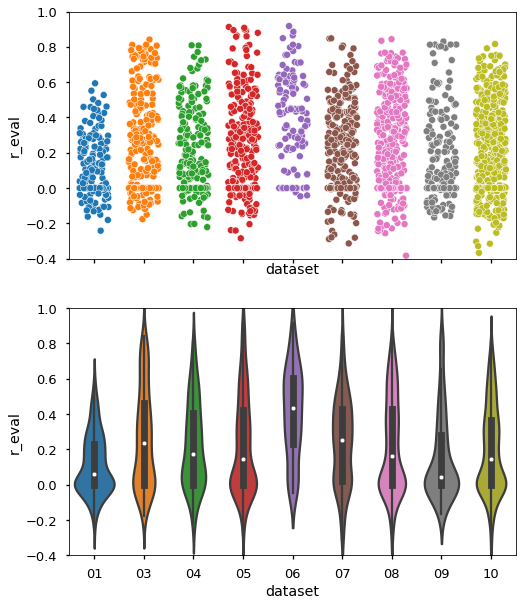

In [6]:
fig,axs = plt.subplots(2,1,sharey=True,sharex=True,figsize=(8,10))
sns.stripplot(x='dataset',y='r_eval',data=eval_df,jitter=.3,linewidth=0.5,edgecolor='white',size=7,ax=axs[0])
sns.violinplot(x='dataset',y='r_eval',data=eval_df,ax=axs[1])
r_ylim = (-0.4,1.0)
plt.ylim(r_ylim);

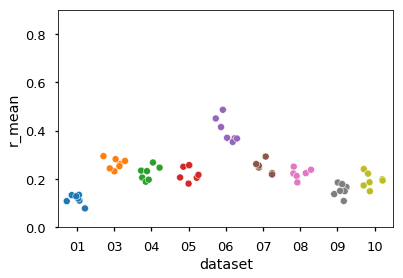

In [7]:
mean_agg = eval_df.groupby(['dataset','t_run','trial']).mean()
r_mean = mean_agg.r_eval
sns.stripplot(x='dataset',y='r_eval',data=r_mean.reset_index(),jitter=0.3,linewidth=0.5,size=7,edgecolor='white')
plt.ylim(0,0.9)
plt.ylabel('r_mean');

In [8]:
mean_agg.head()

baseline_loss  earlystop_frac  fileindex  \
dataset t_run      trial                                             
01      1528574265 1           0.075030        0.142857        0.0   
        1528574580 2           0.086641        0.142857        0.0   
        1528574893 3           0.089622        0.142857        0.0   
        1528745268 4           0.075289        0.142857        0.0   
        1528746676 5           0.090265        0.142857        0.0   

                          learning_rate      loss  max_steps  neuron  \
dataset t_run      trial                                               
01      1528574265 1              0.001  0.092126    35000.0    13.5   
        1528574580 2              0.001  0.089439    35000.0    13.5   
        1528574893 3              0.001  0.079240    35000.0    13.5   
        1528745268 4              0.001  0.089961    35000.0    13.5   
        1528746676 5              0.001  0.087948    35000.0    13.5   

                            r_eval     step  variance  
dataset t_run      trial                               
01      1528574265 1      0.110051   7500.0  0.073248  
        1528574580 2      0.132875  12500.0  0.084546  
        1528574893 3      0.107736  16500.0  0.087131  
        1528745268 4      0.118786  12500.0  0.074182  
        1528746676 5      0.134095  10500.0  0.088333

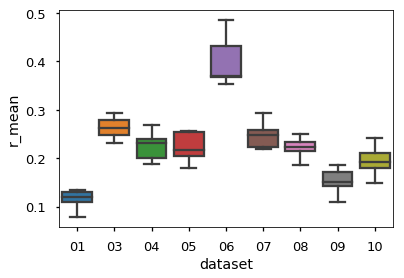

In [9]:
r_mean = eval_df.groupby(['max_steps','dataset','trial']).mean().r_eval
sns.boxplot(x='dataset',y='r_eval',data=r_mean.reset_index())
# plt.ylim(0,0.6)
plt.ylabel('r_mean');

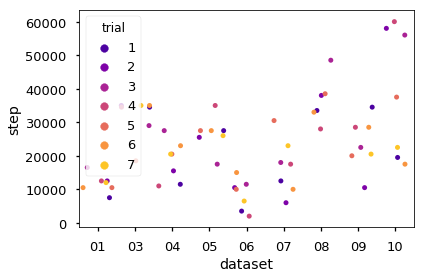

In [10]:
best_step = mean_agg[['step','max_steps']].reset_index()
sns.stripplot(x='dataset',y='step',hue='trial',data=best_step,jitter=0.4,palette='plasma')

In [11]:
best_step[best_step.step > 0.75*best_step.max_steps]

,dataset,t_run,trial,step,max_steps
7,03,1528574423,1,34500.0,35000.0
8,03,1528574735,2,34999.0,35000.0
9,03,1528575053,3,29000.0,35000.0
10,03,1528745424,4,34500.0,35000.0
12,03,1528748231,6,34999.0,35000.0
13,03,1528749641,7,34999.0,35000.0
16,04,1528577617,3,27500.0,35000.0
21,05,1528575565,1,27500.0,35000.0
24,05,1528745733,4,34999.0,35000.0
25,05,1528747145,5,27500.0,35000.0


In [16]:
import scipy.io as sio

In [18]:
cols = ['dataset','trial','neuron','r_eval']
data = eval_df[cols].values

In [19]:
sio.savemat('./lnln_eval_reults.mat',{'columns':cols,'results':data})